In [1]:
import numpy as np
import datetime
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, Dataset,TensorDataset, random_split
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

2024-02-08 16:55:23.435818: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 16:55:23.626742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 16:55:23.626776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 16:55:23.639333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 16:55:23.668440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 16:55:23.669319: I tensorflow/core/platform/cpu_feature_guard.cc:1

The Class

In [2]:
# A completely empty class
class StepByStep(object): 
    pass


The constructor : Define parts(attributes) that make up the class  

 Typical attributes include:
 * arguments provided by user
 * placehlders for other objects that are currently unavailable
 * variables that needed be tracked of
 * functions that are dynamically built

### 1. Arguments

In [3]:
class StepByStep(object):
    def __init__(self,model,loss_fn,optimizer):
        # Here we use define the attributes of our class
        # We start by storing the arguments as attributes to use later
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda' if torch.cuda.is_aviailable() else 'cpu'
        # lets send the model to the device
        self.model.to(self.device)

    def to(self,device):
        # This method allows the user to specify a different device
        # It sets corresponding attribute and sends the model to device
        try:
            self.device=device
            self.model.to(self.device)
        except RuntimeError: # runtime error is raised if the device is not avilaible
            self.device=('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Couldnt send it to {device}, sending it to {self.device} instead")
            self.model.to(self.device)

### 2. Placeholders/delayed arguments
ex: Train and val loaders, summary writer

In [4]:
class StepByStep(object):
    # constructor
    def __init__(self,model,loss_fn,optimizer):
        # Here we use define the attributes of our class
        # We start by storing the arguments as attributes to use later
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda' if torch.cuda.is_aviailable() else 'cpu'
        # Placeholders
        self.train_loader=None
        self.val_loader=None
        self.writer=None
        # lets send the model to the device
        self.model.to(self.device)

    def to(self,device):
        # This method allows the user to specify a different device
        # It sets corresponding attribute and sends the model to device
        try:
            self.device=device
            self.model.to(self.device)
        except RuntimeError: # runtime error is raised if the device is not avilaible
            self.device=('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Couldnt send it to {device}, sending it to {self.device} instead")
            self.model.to(self.device)

    def set_loaders(self,train_loader,val_loader=None):
        # This method allows the user to specify the which loader to use
        # Both loaders are then assign to corresponding attributes
        self.train_loader=train_loader
        self.val_loader=val_loader

    def set_tensorboard(self,name,folder='runs'):
        # This method allows the user to create a summarywriter to interface with tensorboard.
        suffix=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer=SummaryWriter(f"{folder}/{name}_{suffix}")
 



### 3. Variables  
### 4. Functions

In [5]:
class StepByStep(object):
    # constructor
    def __init__(self,model,loss_fn,optimizer):
        # Here we use define the attributes of our class
        # We start by storing the arguments as attributes to use later
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda' if torch.cuda.is_aviailable() else 'cpu'
        # Placeholders
        self.train_loader=None
        self.val_loader=None
        self.writer=None
        # variables that needs to be keep track of
        self.losses=[]
        self.val_losses=[]
        self.total_epochs=0
        # create  train step function for model, loss function and optimizer
        self.train_step_fn=self._make_train_step_fn() # There are no arguments. It make use of class attributes directly
        # create validation step function for model and loss function
        self.val_step_fn=self._make_val_step_fn()
        # lets send the model to the device
        self.model.to(self.device)

    def to(self,device):
        # This method allows the user to specify a different device
        # It sets corresponding attribute and sends the model to device
        try:
            self.device=device
            self.model.to(self.device)
        except RuntimeError: # runtime error is raised if the device is not avilaible
            self.device=('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Couldnt send it to {device}, sending it to {self.device} instead")
            self.model.to(self.device)

    def set_loaders(self,train_loader,val_loader=None):
        # This method allows the user to specify the which loader to use
        # Both loaders are then assign to corresponding attributes
        self.train_loader=train_loader
        self.val_loader=val_loader

    def set_tensorboard(self,name,folder='runs'):
        # This method allows the user to create a summarywriter to interface with tensorboard.
        suffix=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer=SummaryWriter(f"{folder}/{name}_{suffix}")
 

## Step Methods

In [6]:
class StepByStep(object):
    # constructor
    def __init__(self,model,loss_fn,optimizer):
        # Here we use define the attributes of our class
        # We start by storing the arguments as attributes to use later
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda' if torch.cuda.is_available() else 'cpu'
        # Placeholders
        self.train_loader=None
        self.val_loader=None
        self.writer=None
        # variables that needs to be keep track of
        self.losses=[]
        self.val_losses=[]
        self.total_epochs=0
        # create  train step function for model, loss function and optimizer
        self.train_step_fn=self._make_train_step_fn() # There are no arguments. It make use of class attributes directly
        # create validation step function for model and loss function
        self.val_step_fn=self._make_val_step_fn()
        # lets send the model to the device
        self.model.to(self.device)

    def to(self,device):
        # This method allows the user to specify a different device
        # It sets corresponding attribute and sends the model to device
        try:
            self.device=device
            self.model.to(self.device)
        except RuntimeError: # runtime error is raised if the device is not avilaible
            self.device=('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Couldnt send it to {device}, sending it to {self.device} instead")
            self.model.to(self.device)

    def set_loaders(self,train_loader,val_loader=None):
        # This method allows the user to specify the which loader to use
        # Both loaders are then assign to corresponding attributes
        self.train_loader=train_loader
        self.val_loader=val_loader

    def set_tensorboard(self,name,folder='runs'):
        # This method allows the user to create a summarywriter to interface with tensorboard.
        suffix=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer=SummaryWriter(f"{folder}/{name}_{suffix}")

    def _make_train_step_fn(self):
        # This method is a closure that makes the train_step-function. closure is a function that returns a function
        # it can directly use the class attributes
        def perform_train_step_fn(x,y):
            # set model to train mode
            self.model.train()
            # compute models prediction
            yhat=self.model(x)
            # compute the loss
            loss=self.loss_fn(y,yhat)
            # compute gradients
            loss.backward()
            # Update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Return the loss
            return loss.item()
        return perform_train_step_fn
    
    def _make_val_step_fn(self): # we use self here since we need to access class attributes
        def perform_val_step_fn(x,y):
            # set model to eval mode
            self.model.eval()
            # forward pass
            yhat=self.model(x)
            # compute loss
            loss=self.loss_fn(yhat,y)
            # since we dont update paramaters, no need to backprop
            return loss.item()
        return perform_val_step_fn

`    METHODS`: Public  
`    _METHODS`: Protected; supposed to be called either internally or child class  
`    __METHODS`: Private; supposed to be called exclusively internally  

In [7]:
# using SETATTR for educational purposes only
# setattr(StepByStep,'_make_train_step_fn',_make_train_step_fn) # setattr is used to add attributes to a class
# setattr(StepByStep,'_make_val_step_fn',_make_val_step_fn)

In [8]:
class Dog(object):
    def __init__(self,name):
        self.name=name
    

In [9]:
rex=Dog('Rex')
print(rex.name)

# rex is an instance of Dog class. instnace is an object of a class

Rex


In [10]:
def bark(dog): # bark function takes a dog object as an argument
    print(f"{dog.name} barks!: Woof!") 

In [11]:
bark(rex)

Rex barks!: Woof!


In [12]:
# we want bark function to be a method of Dog class
def bark(self):
    print(f"{self.name} barks!: Woof!")

setattr(Dog,'bark',bark) # we add bark function to Dog class, setattr is used to add attributes to a class. Method is also  an attribute, so we can add methods to a class using setattr

In [13]:
fido=Dog('Fido')
fido.bark()

Fido barks!: Woof!


In [14]:
rex.bark()
# we effectively modified the underlying Dog class

Rex barks!: Woof!


In [15]:
def get_name_length(self):
    return len(self.name)
setattr(Dog,'NameLength',get_name_length)

In [16]:
rex.NameLength()

3

## Training methods

In [17]:
def _mini_batch(self,validation=False):
    # mini batch function can be used with both loaders
    # The argument validation is used to determine which loader to use
    if validation:
        data_loader=self.val_loader
        step_fn=self.val_step_fn
    else:
        data_loader=self.train_loader
        step_fn=self.train_step_fn

    if data_loader is None:
        return None
    
    # Once the data loader and setp function are set, we can use same mini batch loop that we used earlier
    mini_batch_losses=[]
    for X_batch, y_batch in data_loader:
        X_batch=X_batch.to(self.device)
        y_batch=y_batch.to(self.device)

        mini_batch_loss=step_fn(X_batch,y_batch)
        mini_batch_losses.append(mini_batch_loss)
    loss=np.mean(mini_batch_losses)
    return loss

setattr(StepByStep,'_mini_batch',_mini_batch) # setattr take 3 arguments; class name, attribute name and the function


In [18]:
def set_seed(self,seed=42):
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False 
    torch.manual_seed(seed)
    np.random.seed(seed)

setattr(StepByStep,'set_seed',set_seed)

In [19]:
# Training loop
def train(self,n_epochs,seed=42):
    # to ensure the reproducilbility of the training process
    self.set_seed(seed)

    for epoch in tqdm(range(n_epochs)):
        # keep track of the number of epochs
        self.total_epochs+=1

        # inner loop
        loss=self._mini_batch(validation=False)
        self.losses.append(loss)

        # validation
        # No grads in validation
        with torch.no_grad():
            val_loss=self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # If a SummaryWriter is set,
            if self.writer:
                scalars={'training':loss} # Record the training loss
                if val_loss is not None:
                    scalars.update({'validation':val_loss})
                # Record both losses for each epoch under tag 'loss'
                self.writer.add_scalars(main_tag='loss',tag_scalar_dict=scalars,global_step=epoch)

    if self.writer:
        # flushes the writer
        self.writer.flush # writer will write everything to disk
    
setattr(StepByStep,'train',train)

In [20]:
# saving checkpoints; checkponit is a snapshot of the model at  a given time
def save_checkpoint(self,filename):
    # Build a dictionary with all the elements for resume training
    checkpoint={'epoch':self.total_epochs,
                'model_state_dict':self.model.state_dict(),
                'optimizer_state_dict':self.optimizer.state_dict(),
                'loss':self.losses,
                'val_loss':self.val_losses}
    torch.save(checkpoint,filename)

setattr(StepByStep,'save_checkpoint',save_checkpoint)


In [21]:
# Loading
def load_checkpoint(self,filename):
    checkpoint=torch.load(filename)
    # Restore state for the model and optimizer
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.total_epochs=checkpoint['epoch']
    self.losses=checkpoint['loss']
    self.val_losses=checkpoint['val_loss']
    self.model.train() # always use TRAIN for Resume training 

setattr(StepByStep,'load_checkpoint',load_checkpoint)

In [22]:
# Making Predictions
def predict(self,x):
    # set the model to evaluation mode
    self.model.eval()
    # take a numpy input and make a float tensor
    x_tensor=torch.as_tensor(x).float()
    # send inpur to device and use model for prediction
    y_hat_tensor=self.model(x_tensor.to(self.device))
    # set model back to train mode because we are done with prediction
    self.model.train()
    # return the predictions as numpy array
    return y_hat_tensor.detach().cpu().numpy() # detch is used to remove the tensor from the computational graph. computational graph: a way to keep track of the operations that are performed on the tensor

setattr(StepByStep,'predict',predict)


In [23]:
# visualization methods
# losses
def plot_losses(self):
    fig=plt.figure(figsize=(10,4))
    plt.plot(self.losses,label='Training Loss',c='b')
    if self.val_loader:
        plt.plot(self.val_losses,label='Validation Loss',c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

setattr(StepByStep,'plot_losses',plot_losses)

In [24]:
# model graph
def add_graph(self):
    if self.train_loader and self.writer:
        # fetch a single mini batch so we can use add_graph
        x_dummy,y_dummy=next(iter(self.train_loader))
        self.writer.add_graph(self.model,x_dummy.to(self.device)) # we dont use y_dummy because it is not used in forward pass

setattr(StepByStep,'add_graph',add_graph)

## Classy Pipeline

In [25]:
%run -i data_generation/simple_linear_regression.py 

We only keep elements that needed to be passed as arguments to StepByStep class

In [26]:
%%writefile model_configuration/v4.py
lr=0.1

torch.manual_seed(42)
# Create a model
model=nn.Sequential(nn.Linear(1,1))

# define SGD Optimizer
optimizer=optim.SGD(model.parameters(),lr=lr)

# Define MSE Loss function
loss_fn=nn.MSELoss(reduction='mean')


Overwriting model_configuration/v4.py


In [27]:
%run -i model_configuration/v4.py

In [28]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


## Model Training

In [29]:
%run -i data_preparation/v2.py

In [30]:
sbs=StepByStep(model,loss_fn,optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('classy')

In [31]:
print(sbs.model)


Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [32]:
# train our model
sbs.train(n_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])

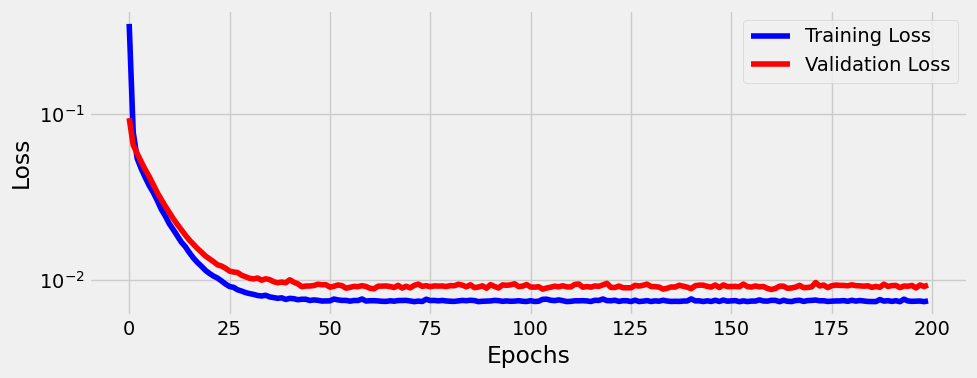

In [34]:
fig=sbs.plot_losses()

## Making predictions

In [35]:
new_data=np.array([0.5,0.3,0.7]).reshape(-1,1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [36]:
predictions=sbs.predict(new_data)
predictions

array([[1.9942763],
       [1.605955 ],
       [2.3825974]], dtype=float32)

## Checkpointing

In [37]:
sbs.save_checkpoint('model_checkpoint.pth')

## Resume Training

In [38]:
%run -i model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [39]:
# Untrained model
model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])

In [40]:
new_sbs=StepByStep(model,loss_fn,optimizer)

In [41]:
# load trained model
new_sbs.load_checkpoint('model_checkpoint.pth')
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])

In [42]:
new_sbs.set_loaders(train_loader,val_loader)
new_sbs.train(n_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

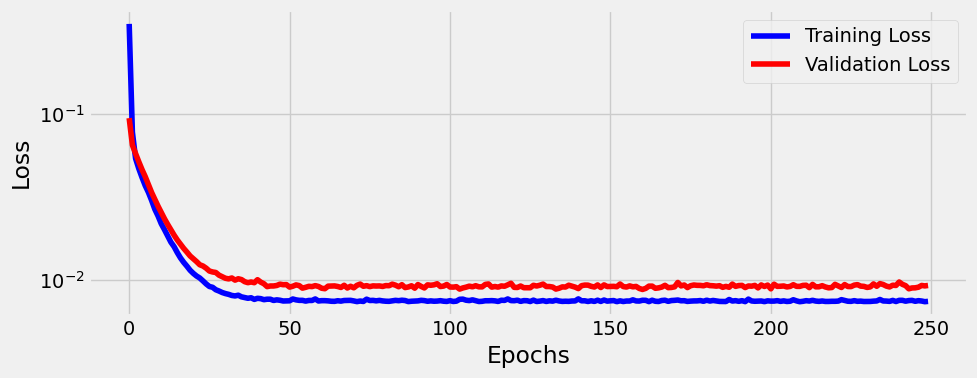

In [43]:
fig=new_sbs.plot_losses()